<a href="https://colab.research.google.com/github/noussayma/ml-student/blob/main/Land_Cover_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land Cover Type Classification with PyTorch

This notebook serves as a starting point for your machine learning project on land cover type classification.

The task at hand involves classifying land cover types, such as 'Forest,' 'River,' 'Highway,' and more, based on satellite images. The dataset consists of images labeled with their corresponding land cover types. The goal is to train a machine learning model that can accurately predict the land cover type of new, unseen images.

In this notebook, you'll find code snippets to load and visualize the data, providing insights into the images and their labels.

## Build Your Model

You have the freedom to choose the architecture or model for your land cover classification task. Whether you opt for a simple convolutional neural network (CNN) or explore transfer learning with pre-trained models, the notebook provides a flexible starting point. Experiment with different architectures to achieve the best performance.

## Model Training and Evaluation

Once your model is defined, the notebook guides you through the process of training it on the dataset. Additionally, it includes code to evaluate the model's performance on the validation and test sets.

Feel free to modify, experiment, and enhance the provided code. Happy coding !

Please submit your weekly assignments to me via [email](mailto:elmontassir@cerfacs.fr) to receive your score on the test set.



# Data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [ ]:
# Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2023-12-29 21:05:39 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar" [1]
2023-12-29 21:05:42 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar" [1]
2023-12-29 21:05:44 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy" [1]


In [ ]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [ ]:
X_train = extract_files('TRAIN')
X_test = extract_files('TEST')
y_train = np.load('y_train.npy').reshape(-1, 1)
print("Train data : ",X_train.shape)
print("Train labels", y_train.shape)
print("Test data : ",X_test.shape)

Train data :  (20000, 64, 64, 3)
Train labels (20000, 1)
Test data :  (7000, 64, 64, 3)


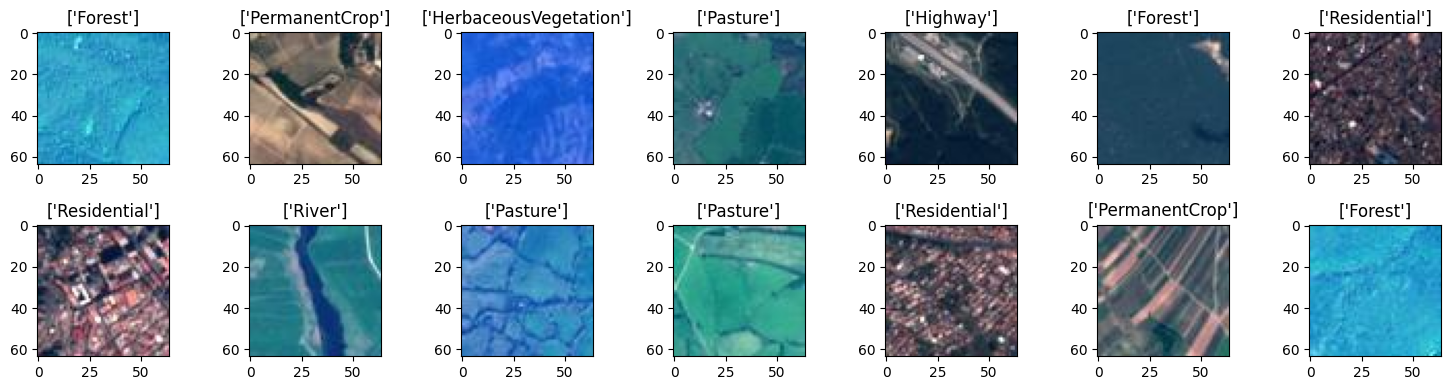

In [ ]:
# Display data samples
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()
for i in range(14):
    axes[i].imshow(X_train[i])
    axes[i].set_title(y_train[i])
plt.tight_layout()

There are 10 possible classes for each image (only one per image is correct):

  - 'AnnualCrop'
  - 'Forest'
  - 'HerbaceousVegetation'
  - 'Highway'
  - 'Industrial'
  - 'Pasture'
  - 'PermanentCrop'
  - 'Residential'
  - 'River'
  - 'SeaLake'

We could simply code an integer value for each: 'AnnualCrop' = 0, 'Forest' = 1, etc... This is known as "Ordinal Encoding", and has some drawbacks, e.g. if the network is unsure whether it is class 0 or 2, it could end up saying 1, which is another class altogether. When categories have a natural order, ordinal encoding can be a good way to go. Here, this is not the case.

The most classical way to convert the type of labels here to numeric values is through [**one-hot encoding**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features). In this process, the label is converted to a vector with length the number of possible labels, and only the one matching the true label is set to 1, all others are set to 0.

|                 | Type1 | Type2 | Type3 |   | Label Vector |
|-----------------|:-----:|:-----:|:-----:|---|:------------:|
| Sample1: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample2: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample3: Type 1 |   1   |   0   |   0   |   |   [1, 0, 0]  |
| ...             |       |       |       |   |              |

Scikit-learn has a useful class for this, [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which does this automatically. More importantly, it remembers the encoding, and you can use it again after making your final predictions te *decode* them back to text labels, as expected by the competition.

In [ ]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()

# Model

Note: the images here are encoded with 8-bit integers, *i.e.* between 0 and 255. A normalization is needed.

In [ ]:
# Prepare data for training
X_train, X_test = X_train/255, X_test/255
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
print(mean)
print(std)

[0.29088279 0.41201959 0.48920503]
[0.2240432  0.17601508 0.21699366]


The normalization coefficients for the mean and standard deviation are commonly used for image data normalization within the range of [0, 255] or [0, 1]. This process brings pixel values into a standard range centered around zero, facilitating the acceleration of neural network training. In this case, we begin by dividing by 255 to scale values to [0, 1]. Subsequently, subtracting the mean centers the range around zero, and dividing by the standard deviation reduces the range to a centered Gaussian distribution, promoting stability.

Normalization coefficients may vary depending on the dataset, image characteristics, and network architecture. Experimenting with different strategies is common in model development. For specific datasets, calculating the mean and standard deviation directly from the training data can provide a good normalization.

In [ ]:
# Assuming X_train and y_train are PyTorch tensors
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and normalize images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

X_train_tensor = torch.stack([transform(img) for img in X_train]).float()
X_valid_tensor = torch.stack([transform(img) for img in X_valid]).float()
X_test_tensor = torch.stack([transform(img) for img in X_test]).float()
y_train_tensor = torch.from_numpy(y_train)
y_valid_tensor = torch.from_numpy(y_valid)

In [ ]:
# Define the simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(64, 1024)
        # self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.global_avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# Augmentation transforms for training data
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

# Create TensorDataset for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.argmax(dim=1))
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor.argmax(dim=1))

# Set up augmentation for the training dataset
train_dataset.transform = augmentation_transform

# Define DataLoader for training with augmentation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Define DataLoader for validation without augmentation
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
# # Instantiate the model
model = SimpleCNN().to(device)

# # Print the model architecture
print(model)

# # # Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())  # You can set learning rate, weight decay, etc.

# #################################
# # Suggested values for hyperparameters
learning_rate = 0.001  # Starting with a small learning rate
momentum = 0.9  # A common momentum value
weight_decay = 1e-4  # A small weight decay value

# # Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
# #################################

# # Training loop
num_epochs = 30
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.argmax(dim=1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor.argmax(dim=1))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=64, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn


def train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_valid_loss = float('inf')
    current_patience = 0

    # Lists to store metrics
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            loss.backward()
            optimizer.step()

        train_accuracy = 100 * correct_train / total_train
        training_losses.append(train_loss / len(train_loader))
        training_accuracies.append(train_accuracy)

        true_labels, predicted_labels = [], []
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        model.eval()
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                total_valid += labels.size(0)
                correct_valid += predicted.eq(labels).sum().item()
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        valid_accuracy = 100 * correct_valid / total_valid
        validation_losses.append(valid_loss / len(valid_loader))
        validation_accuracies.append(valid_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {training_losses[-1]:.3f}, Training Accuracy: {training_accuracies[-1]:.2f}%, '
              f'Validation Loss: {validation_losses[-1]:.3f}, Validation Accuracy: {validation_accuracies[-1]:.2f}%')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            current_patience = 0
        else:
            current_patience += 1
        if current_patience >= patience:
            print(f'Early stopping! Validation loss hasn\'t improved for {patience} epochs.')
            break

    return training_losses, training_accuracies, validation_losses, validation_accuracies, true_labels, predicted_labels


In [ ]:
# Define hyperparameters for the grid search
param_grid = {
    'learning_rate': [0.01],
    'momentum': [0.95],
    'weight_decay': [1e-4]

}
##  0.01, momentum: 0.95, weight decay: 0.0001

# Perform grid search
for params in ParameterGrid(param_grid):
    print(f"Training with learning rate: {params['learning_rate']}, momentum: {params['momentum']}, weight decay: {params['weight_decay']}")

    # Create DataLoader with the current batch size
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor.argmax(dim=1))
    valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor.argmax(dim=1))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    # Instantiate the model
    model = SimpleCNN()

    # Define the loss function and optimizer with the current hyperparameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'], weight_decay=params['weight_decay'])

    # Perform training and evaluation
    training_losses, training_accuracies, validation_losses, validation_accuracies, true_labels, predicted_labels = train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer)

Training with learning rate: 0.01, momentum: 0.95, weight decay: 0.0001
Epoch 1/100, Training Loss: 1.409, Training Accuracy: 46.91%, Validation Loss: 1.067, Validation Accuracy: 61.58%
Epoch 2/100, Training Loss: 0.960, Training Accuracy: 64.86%, Validation Loss: 0.886, Validation Accuracy: 67.92%
Epoch 3/100, Training Loss: 0.775, Training Accuracy: 71.96%, Validation Loss: 0.694, Validation Accuracy: 74.78%
Epoch 4/100, Training Loss: 0.708, Training Accuracy: 74.54%, Validation Loss: 0.621, Validation Accuracy: 77.97%
Epoch 5/100, Training Loss: 0.639, Training Accuracy: 77.30%, Validation Loss: 0.595, Validation Accuracy: 79.08%
Epoch 6/100, Training Loss: 0.566, Training Accuracy: 79.37%, Validation Loss: 0.573, Validation Accuracy: 79.97%
Epoch 7/100, Training Loss: 0.519, Training Accuracy: 81.64%, Validation Loss: 0.541, Validation Accuracy: 80.72%
Epoch 8/100, Training Loss: 0.469, Training Accuracy: 83.35%, Validation Loss: 0.476, Validation Accuracy: 83.78%
Epoch 9/100, Tra

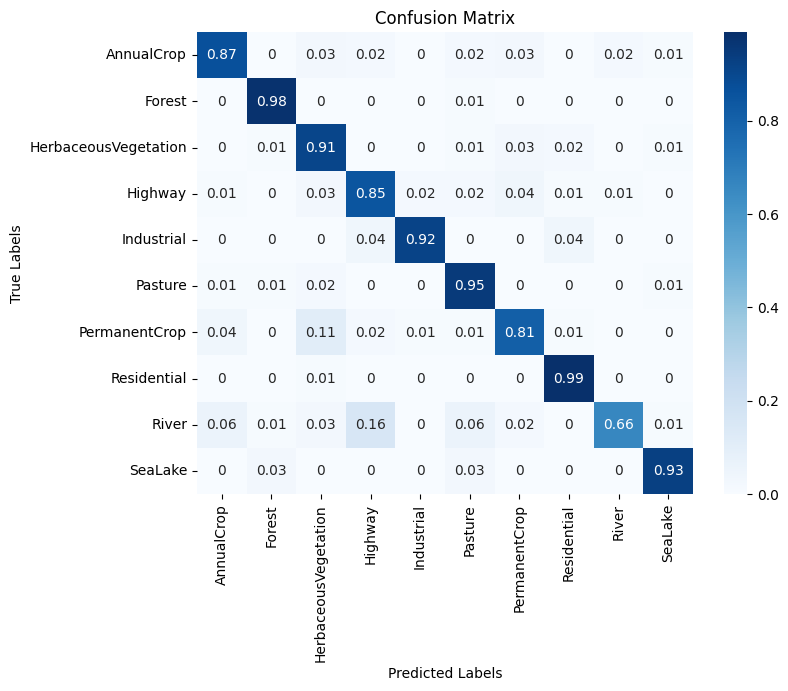

In [ ]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


confusion_matrix_result = confusion_matrix(true_labels, predicted_labels)
confusion_matrix_result = np.round(confusion_matrix_result.astype('float') / confusion_matrix_result.sum(axis=1)[:, np.newaxis], 2)
classes = encoder.categories_[0]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy for AnnualCrop: 87.00%
Accuracy for Forest: 98.99%
Accuracy for HerbaceousVegetation: 91.92%
Accuracy for Highway: 85.86%
Accuracy for Industrial: 92.00%
Accuracy for Pasture: 95.00%
Accuracy for PermanentCrop: 80.20%
Accuracy for Residential: 99.00%
Accuracy for River: 65.35%
Accuracy for SeaLake: 93.94%


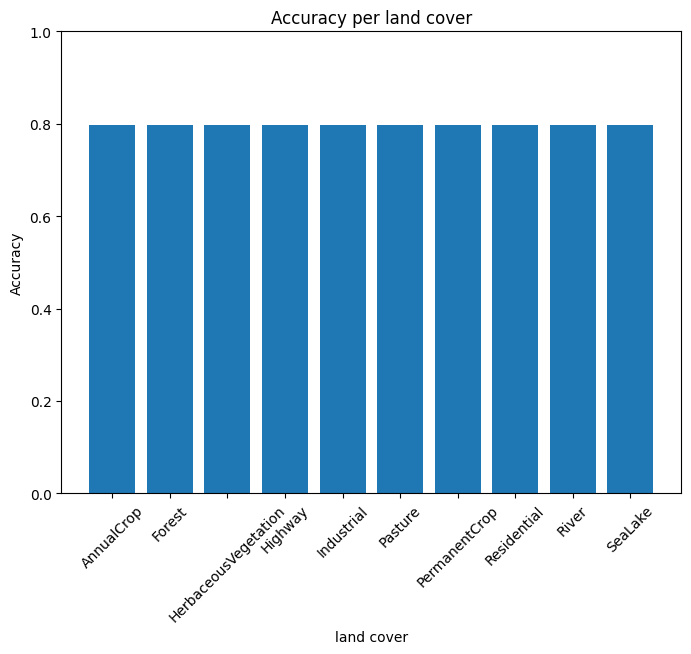

In [ ]:


#  Accuracy per class

num_classes = len(classes)
accuracy_per_class = [confusion_matrix_result[i, i] / np.sum(confusion_matrix_result[i, :]) for i in range(num_classes)]

for i, label in enumerate(classes):
    print(f'Accuracy for {label}: {accuracy_per_class[i]*100:.2f}%')


plt.figure(figsize=(8, 6))
plt.bar(classes, accuracy)
plt.xlabel('land cover')
plt.ylabel('Accuracy')
plt.title('Accuracy per land cover')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.show()



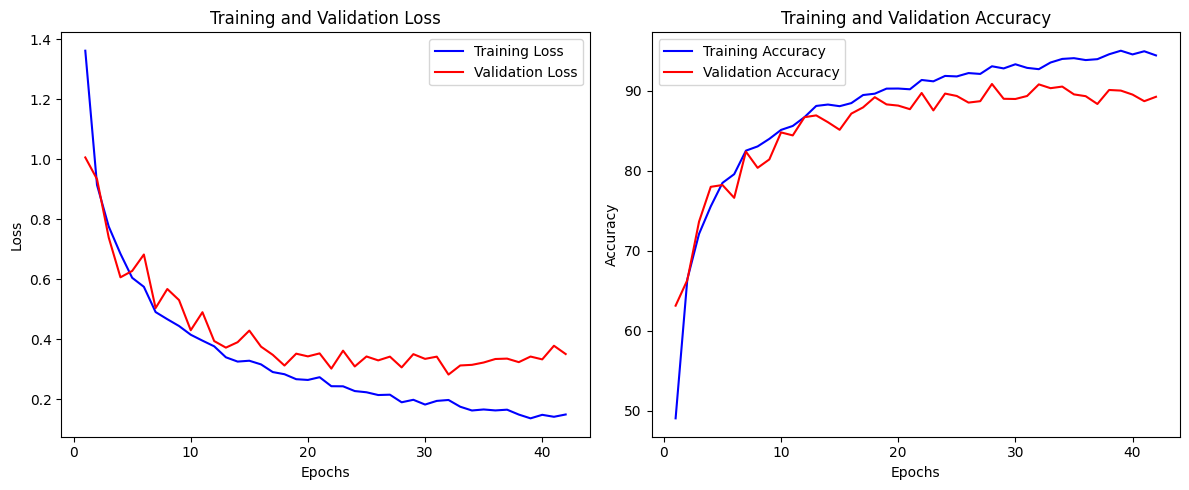

In [ ]:
# Plotting
epochs = range(1, len(training_losses) + 1)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, 'b-', label='Training Loss')
plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Create Your Submission

In [ ]:
# Function to create a submission file
def create_submission(predictions):
    assert predictions.shape == (7000, 1), f"Wrong shape for your prediction file : {predictions.shape} instead of (7000, 1)"
    with open('predictions.npy', 'wb') as f:
      np.save(f, predictions)
    print("File predictions.npy created !")

In [ ]:
# Generate predictions
bs = 35
predictions = np.ones((X_test_tensor.shape[0],10))
for i in range(X_test_tensor.shape[0]//bs):
  predictions[bs*i:bs*(i+1),:] = model(X_test_tensor[bs*i:bs*(i+1)].to(device)).cpu().detach().numpy()
print(predictions[:5])

# Get labels
predictions = encoder.inverse_transform(predictions)
print(predictions[:5])

# Create a submission using the provided function
NAME = "DJAIDER & OUAHI & SRAIDI & CHARIFI"
NUMBER = 1
create_submission(predictions)

[[ 4.77157164  3.62324762 -1.07783222 -1.1615088  -7.29586792 12.9026413
  -5.55545044 -6.24979019  0.52022719 -0.55544806]
 [-4.29057312 -7.82590675 -1.81385875  2.97369242 12.63961887 -1.86877966
   1.64047158  2.90497088  0.26262274 -3.68651509]
 [ 1.86427438 -4.19209385  4.00560856  4.31806326 -2.40010405 -1.81464434
   9.79987335 -2.99314189 -4.39325905 -3.93580961]
 [ 2.88242459 12.40729332 -2.49646974 -3.93852615 -7.85013008  1.26604021
  -2.58422089 -0.36397749 -2.24542284  3.16112232]
 [-2.7062633   0.86614764  1.84697723  1.9521426  -3.24813223 -1.95861959
  -3.80832243 -1.63184631  8.5988903   0.46769941]]
[['Pasture']
 ['Industrial']
 ['PermanentCrop']
 ['Forest']
 ['River']]
File predictions.npy created !
